In [1]:
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cmcrameri.cm as ccm
from shapely.geometry import Polygon
from cartopy.geodesic import Geodesic
import cartopy.feature as cfeature

In [5]:
# Set region name
name = 'Stromboli'
start_date = '2018-06-01'
end_date = '2025-11-01'

# Read in the region details
with open('regions.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)[name]

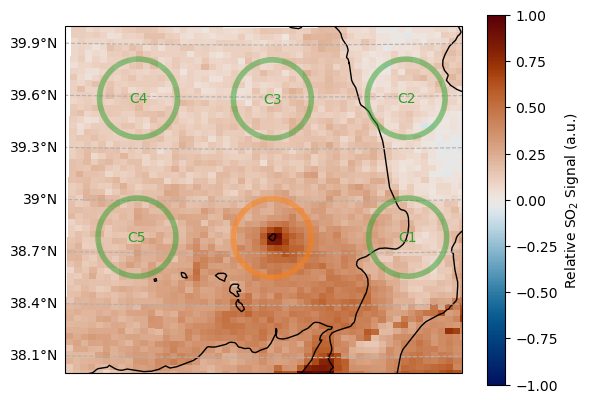

In [ ]:
vlat, vlon = config['vent_location']

fig, ax = plt.subplots(
    subplot_kw={
        'projection': ccrs.Orthographic(vlon, vlat),
        'extent': config['bounds']
    }
)
srcrs = ccrs.PlateCarree()

ax.coastlines()
gl = ax.gridlines(ls='--', draw_labels=True)
gl.right_labels = False

circles = Polygon(Geodesic().circle(
    vlon, vlat, config['radius'], n_samples=360
))
ax.add_feature(cfeature.ShapelyFeature(
    [circles], srcrs, fc='None', ec="C1", lw=4,
    linestyle="-", zorder=10, alpha=0.5
))

for i, (clat, clon) in enumerate(config['clear_locations']):

    circles = Polygon(Geodesic().circle(
        clon, clat, config['radius'], n_samples=360
    ))
    ax.add_feature(cfeature.ShapelyFeature(
        [circles], srcrs, fc='None', ec="C2", lw=4,
        linestyle="-", zorder=10, alpha=0.5
    ))
    ax.text(
        clon, clat, f'C{i+1}', color='C2', ha='center', va='center',
        transform=srcrs
    )

fname = f"{name}_{start_date}_{end_date}_so2_data.nc"

# Open the file
with xr.open_dataset(fname) as ds:

    so2 = ds.SO2.sum(axis=0)
    so2 = so2 / np.abs(np.max(so2))

    m = ax.pcolormesh(
        ds.x, ds.y, so2, transform=srcrs, cmap=ccm.vik, vmin=-1, vmax=1
    )
    plt.colorbar(m, ax=ax, label='Relative SO$_2$ Signal (a.u.)')

plt.show()

In [ ]:
# Read in time series data
df = pd.read_csv(f'{name}_{start_date}_{end_date}_SO2_time_series.csv', parse_dates=['date'])

# Replace all zeros with NaN values
df.replace(0, np.nan, inplace=True)

# Fill in with interpolated values
df.interpolate(inplace=True)


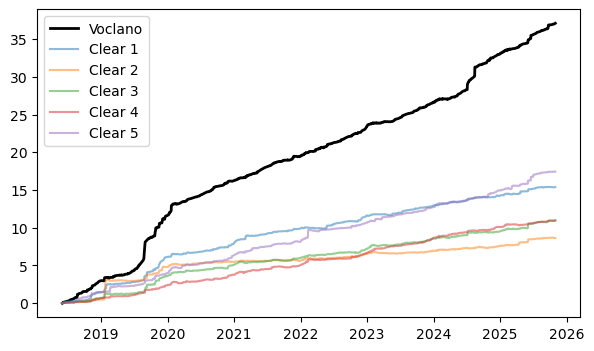

In [ ]:
# Plot the raw data
fig, ax = plt.subplots(figsize=[7, 4])

ax.plot(df['date'], np.cumsum(df['volcano']), label='Volcano', color='k', lw=2)
for i in range(len(config['clear_locations'])):
    ax.plot(df['date'], np.cumsum(df[f'clear_{i+1}']), f'C{i}-', alpha=0.5, label=f'Clear {i+1}')

ax.legend()

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.show()

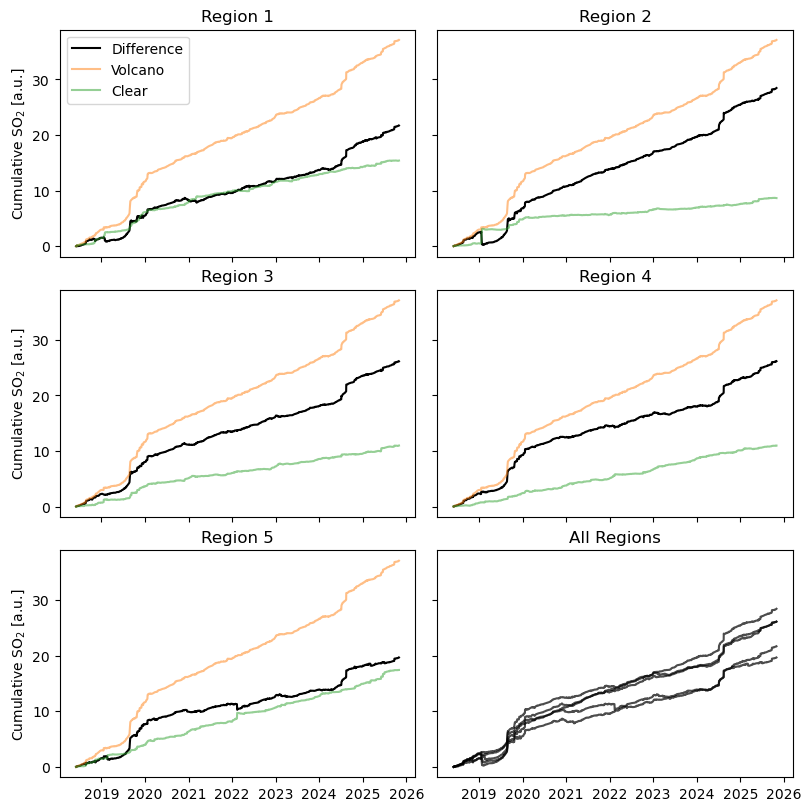

In [22]:
# Plot the clear-corrected data

fig, axes = plt.subplots(
    3, 2, sharex=True, sharey=True, constrained_layout=True, figsize=[8, 8]
)

for i, ax in enumerate(axes.ravel()[:-1]):

    axes.ravel()[-1].plot(
        df['date'], np.cumsum(df['volcano'] - df[f'clear_{i+1}']),
        'k-', alpha=0.7
    )

    ax.plot(
        df['date'], np.cumsum(df['volcano'] - df[f'clear_{i+1}']),
        'k-', label='Difference'
    )

    ax.plot(
        df['date'], np.cumsum(df['volcano']),
        'C1-', alpha=0.5, label='Volcano'
    )

    ax.plot(
        df['date'], np.cumsum(df[f'clear_{i+1}']),
        'C2-', alpha=0.5, label='Clear'
    )

    ax.set_title(f'Region {i+1}')

    if i == 0:
        ax.legend()
    if i in [0, 2, 4]:
        ax.set_ylabel('Cumulative SO$_2$ [a.u.]')

axes.ravel()[-1].set_title('All Regions')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
axes.ravel()[-1].xaxis.set_major_locator(locator)
axes.ravel()[-1].xaxis.set_major_formatter(formatter)

plt.show()

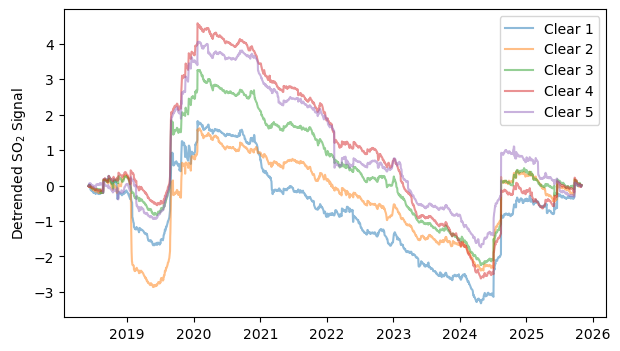

In [23]:
# Plot the clear-corrected and detrended data

fig, ax = plt.subplots(figsize=[7, 4])

for i in range(len(config['clear_locations'])):
    signal = np.cumsum(df['volcano'] - df[f'clear_{i+1}'])
    detrended_signal = np.subtract(
        signal,
        np.polyval(
            [signal.to_numpy()[-1]/len(df['date']), 0],
            np.arange(len(df['date'])))
    )
    ax.plot(
        df['date'],
        detrended_signal,
        f'C{i}-',
        alpha=0.5,
        label=f'Clear {i+1}'
    )

ax.legend()

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_ylabel('Detrended SO$_2$ Signal')

plt.show()